In [1]:
import os 
import time
import copy
import math 
import re
import json 

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import numpy as np
import pickle
import random 
import pandas as pd

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

using device cuda:0


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
def cuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

In [4]:
path = !pwd
path = path[0]
print(path)

/home/r2/Documents/RNNexp


In [5]:
# data = pd.read_pickle(path+"/data/step3_DAT_MT_USDJPY_M1_2018_merged_pickled") 
# data.head()

### functions

In [6]:
class Struct():
    pass 

def load_trumpdata(datapath, pad_tok='£', start_tok='^', end_tok='€'):

    van_tws, tws, van_tw_str, tw_str = [],[],'',''
    filenames = ['condensed_2018.json', 'condensed_2016.json', 'condensed_2017.json', 'condensed_2018.json']
    for fname in filenames:
        f = open(datapath+fname,"r")
        data = f.readline()
        f.close()
        data_tr = json.loads(data)
        for line in range(0,len(data_tr)):
            tweet      = data_tr[line]["text"].rstrip('\\')
            van_tw_str = van_tw_str + tweet 
            van_tws.append(tweet)            
    symbols = list(set(van_tw_str))  
    assert(pad_tok   not in symbols)
    assert(start_tok not in symbols)
    assert(end_tok   not in symbols)

    for tweet in van_tws:
        pad_tweet = start_tok + tweet + end_tok
        tw_str    = tw_str + pad_tweet            
        tws.append(pad_tweet)        
    symbols = [pad_tok, start_tok] + symbols + [end_tok]   
    decoder = {idx: symbols[idx] for idx in range(0,len(symbols))}
    encoder = {symbols[idx]: idx for idx in range(0,len(symbols))}        
    return tws, tw_str, decoder, encoder

def pp_trumpdata(filename, prop, bsize=1):
    Data, train, valid, test = Struct(), Struct(), Struct(), Struct()        
    tweets, tweet_str, Data.decoder, Data.encoder = load_trumpdata(filename)    

    train.tweets = tweets[0:round(prop[0]*len(tweets))]
    train.tweet_str = tweet_str[0:round(prop[1]*len(tweet_str))]    
    valid.tweets = tweets[round(prop[0]*len(tweets)):round(prop[1]*len(tweets))]
    valid.tweet_str = tweet_str[round(prop[0]*len(tweet_str)):round(prop[1]*len(tweet_str))]    
    test.tweets  = tweets[round(prop[1]*len(tweets)):-1]
    test.tweet_str  = tweet_str[round(prop[1]*len(tweet_str)):-1]    

    train.batch_str = []
    stepsize = round(len(train.tweet_str)/bsize-1)
    for i in range(0,bsize):
        train.batch_str.append(train.tweet_str[i*stepsize:(i+1)*stepsize])
    valid.batch_str = [valid.tweet_str]
    
    Data.train, Data.valid, Data.test, Data.bsize = train, valid, test, bsize
    return Data

def save_checkpoint(state, filename='models/checkpoint.pth.tar'):
    torch.save(state, filename)

def load_checkpoint(filename='models/checkpoint.pth.tar'):
    checkpoint = torch.load(filename)    
    for item in iter(checkpoint):
        print(item)
    model = RNN(checkpoint['in_sz'],checkpoint['hd_sz'],checkpoint['out_sz'])
    model.load_state_dict(checkpoint['state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss    


def init_params(in_sz, bs, hd_sz=150):
    Params = Struct()
    Params.ni      = 3000
    Params.ne      = 1
    Params.hd_sz   = hd_sz
    Params.in_sz   = in_sz
    Params.sql     = 10
    Params.iv_pr   = 200
    Params.iv_pl   = 100
    Params.n_e     = 1
    Params.n_i     = 1000
    Params.use_opt = True 
    Params.lr      = 0.0005
    Params.bs      = bs
    return Params

### encoder/decoders 

In [7]:
def encodestr(string, encoder):
    x = torch.zeros((len(string),len(encoder)))
    x[[idx for idx in range(0,len(string))],[encoder[char] for char in string]] = 1
    return x

def onehencode(symbol, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[symbol]] = 1.0
    return x.t()

def encode(string, encoder):
    return torch.Tensor([encoder[char] for char in y_str])

def onehdecode(X,decoder):
    assert(X.shape[-1] == len(decoder))
    string = ''
    for char in range(X.shape[0]):
        val, idx = torch.max(X[char],0)
        string += decoder[idx.item()]
    print(string)
    
def ydecode(Y,decoder):
    string = ''
    for char in range(Y.shape[0]): string += decoder[Y[char].item()]
    print(string)

def change_char(s, p, r):
    return s[:p]+r+s[p+1:] 

def generate_seq(model,Data,sql,symbol='^'):
    with torch.no_grad():
        hidden = model.initHidden(1)
        result = symbol
        for i in range(sql):
            x = cuda(onehencode(symbol,Data.encoder))
            output, hidden = model.forward(x,hidden)        
            hidden = hidden.detach()
            
            prob     = np.exp(output[0].cpu().numpy())
            cum_prob = np.cumsum(prob)
            idx      = np.where(cum_prob - random.random() > 0)[0][0]
            symbol   = Data.decoder[idx]
            result  += symbol
    print(result)

## my RNN module

In [8]:
class RNNoriginal(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNoriginal,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        self.h1  = nn.Linear(input_size + hidden_size, hidden_size)               
        self.o1   = nn.Linear(input_size + hidden_size, input_size)

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)               

        self.o1      = nn.Linear(combined, combined)
        self.bn1     = nn.BatchNorm1d(combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, input_size)
        self.bn2     = nn.BatchNorm1d(input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.bn1(output)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.bn2(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))

def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

def weights_init_xavier(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    

### DataLoaders, Itterators, DataSets

In [46]:
def pad(str_list,sql=1,token='£'):
    f"""pad all strings in a list to max_len"""
    max_len = math.ceil(len(max(str_list, key=len))/sql)*sql
    for idx, row in enumerate(str_list):        
        str_list[idx] = row + token*(max_len-len(row))
    if len(str_list) == 1: return str_list[0]
    return str_list

def mk_tweetbatch(tweets,encoder,bs,sql,symbol='£'):
    assert(math.floor(len(tweets)/bs)==len(tweets)/bs)
    bch       = batch_strings(tweets,bs,sql)[0]
    assert(math.floor(len(bch[0])/sql)==len(bch[0])/sql)            
    n_segment = int(len(bch[0])/sql)
    sbx       = torch.zeros(bs,n_segment,sql,len(encoder))
    sby       = torch.zeros(bs,n_segment,sql).long()
    for tweet in range(bs):
        """for target we don't use first char, compensate with one padded char"""
        y_str = bch[tweet][1:len(bch[tweet])]+symbol      
        
        chng_pos = len(bch[tweet])
        """if we find padded char, we know that tweet ended, remove last char of tweet"""        
        if re.search(symbol,bch[tweet]): chng_pos = re.search(symbol,bch[tweet]).span()[0]       
        x_str = change_char(bch[tweet],chng_pos-1,symbol)     
        
        for segment in range(n_segment):
            x = x_str[sql*segment:sql*(segment+1)]
            y = y_str[sql*segment:sql*(segment+1)]  
            sbx[tweet,segment] = encodestr(x,encoder)
            sby[tweet,segment] = torch.Tensor([encoder[char] for char in y])                    
    return sbx,sby

class TweetDataLoader():
    def __init__(self,data,tweets,bs,sql,shuffle=False):    
        assert(math.floor(len(tweets)/bs)==len(tweets)/bs)
        self.tweets  = tweets
        self.bs      = bs         
        self.sql     = sql
        self.encoder = data.encoder
        self.decoder = data.decoder
        self.i       = -1
        self.shuffle = shuffle        
        
    def reset(self):
        self.i = -1
        
    def __iter__(self):  
        while True:
            self.i+=1
            twt      = self.tweets[self.i*self.bs:(self.i+1)*self.bs]
            sbx,sby  = mk_tweetbatch(twt,self.encoder,self.bs,self.sql)
            sbloader = iter(SBDataLoader(sbx,sby))            
            yield next(sbloader)
            try:
                while True:                
                    yield next(sbloader) 
            except StopIteration:
                pass            
            if self.i==round(len(self.tweets)/self.bs)-1:
                if self.shuffle: random.shuffle(self.tweets)
                break

class SBDataLoader():
    def __init__(self, sbx, sby): 
        self.sbx, self.sby = sbx, sby
    def __iter__(self):
        for j in range(self.sbx.shape[1]): yield cuda(self.sbx[:,j]), cuda(self.sby[:,j])

def batch_strings(tweets,bs,sql=1):
    f"""creates a list of batchsize-list of strings of same length and sort each batch with longest string first."""    
    """NOT SURE ABOUT THIS OFFSET, BUT THE PREVIOUS CODE ALWAYS MADE A 0"""
    offset = -1*((len(tweets)/bs)*10%2!=0)    
#     offset = -1*((math.floor(len(tweets)/bs)==len(tweets)/bs)==0)    
    bch_strs = [] 
    for i in range(round(len(tweets)/bs)+offset):
        strings = tweets[i*bs:(i+1)*bs]
        strings.sort(key=len,reverse=True)
        pad_strings = pad(strings,sql)
        bch_strs.append(pad_strings)
    return bch_strs

### building FastAI classes to be used with callbacks in future


In [44]:
class Learner():
    def __init__(self, model, loss_fn, data):
        opt = optim.RMSprop(model.parameters(), lr=Params.lr)
        assert(model is not None)
        assert(loss_fn is not None)
        assert(data is not None)
        self.model,self.opt,self.loss_fn,self.data = model,opt,loss_fn,data
        

class Callback():
    def begin_fit(self,learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self,epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True 
    def begin_batch(self,xb,yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self,loss):
        self.loss=loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [11]:
cb =  CallBack()

NameError: name 'CallBack' is not defined

In [ ]:
evalcb = TrainEvalCallback()

In [ ]:
evalcb.after_fit()

In [52]:
def fit_rnn(epoches, learn, data, valid_loss=[], cb=None):
    start = time.time()
    for e in range(epoches):
        i = 0
        for xb, yb in data.train_dl:      
            if xb[0,0,1].item() == 1: hidden = learn.model.initHidden(xb.shape[0])                
            learn, hidden, loss = one_rnn_batch(learn,xb,yb,hidden)           
            if (i%100==0): valid_loss.append(get_valid(learn,data))
            i += 1
    return learn, hidden, valid_loss

def one_rnn_batch(learn,xb,yb,hidden):
    loss = 0 
    learn.model.train()
    for char in range(xb.shape[1]):
        x,y = xb[:,char],yb[:,char]

        idx    = zero_idx(y)
        if idx is None: break

        hidden = hidden[idx]
        x      = x[idx]
        y      = y[idx]
        output,hidden = learn.model.forward(x,hidden)
        loss += learn.loss_fn(output,y)                
    if loss != 0:
            
        loss.backward()
        learn.opt.step()
        learn.opt.zero_grad()
        hidden = hidden.detach()
    return learn, hidden, loss

def get_valid_loss(model,data,Params,seq_len,ntweet):
    criterion = nn.NLLLoss()
    start = time.time()
    loss_valid = 0
    hidden = cuda(torch.zeros(1,model.hd_sz))
    with torch.no_grad():    
        model.eval()
        for t in range(ntweet):
            tweet = data.valid.tweets[t]
            xv, yv = generate_valid(data,tweet,seq_len)     
            loss = 0
            for char in range(xv.size()[1]):
                x = xv[:,char,:].reshape(xv.shape[0],xv.shape[2])
                output, hidden = model.forward(x,hidden)
                y = yv[:,char,:]
                loss += criterion(output,y.reshape(xv.shape[0]))
            loss_valid += loss/(xv.size()[2])
#     print(f"calculating validation loss took {time.time()-start:.2f} seconds")
    del criterion
    return loss_valid/ntweet

def generate_valid(data, tweet, seq_len):
    if seq_len > len(tweet)-1: seq_len = len(tweet)-1    
    X = torch.zeros(1,seq_len,len(data.encoder))
    Y = torch.zeros(1,seq_len,1)  
    x = encodestr(tweet[0:seq_len],data.encoder)
    y = torch.Tensor([data.encoder[char] for char in tweet[1:seq_len+1]])
    X[0,:,:] = x.reshape(seq_len,len(data.encoder))
    Y[0,:,:] = y.reshape(seq_len,1)
    return cuda(X),cuda(Y.long())


def get_valid(learn,data):
    learn.model.eval()
    tot_loss = 0 
    nb_it    = 0
    for xb,yb in data.valid_dl:        
        if xb[0,0,1].item() == 1: hidden = learn.model.initHidden(xb.shape[0])            
        learn, hidden, loss = one_rnn_batch(learn,xb,yb,hidden)  
        tot_loss += loss/xb.size()[2]
        nb_it    += 1
    print(f""""getting validation""")
    return tot_loss/nb_it

def zero_idx(y):
    idx = (y != 0).nonzero()
    if idx.shape[0] < 2: return None
    else: idx = idx.squeeze()
    return idx

def stats(i,valid_loss):
    if i%100==0: 
        valid_loss.append(get_valid_loss(learn.model,data,Params,30,50))
    if i%500==0: print(f"""checkpoint: {i} itterations done in {time.time() - start} seconds""")
    i += 1   

In [51]:
bs = 15
data       = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
Params     = init_params(len(data.encoder),bs)
Params.sql = 30
Params.bs  = 15
rnn = cuda(RNN(Params.in_sz, Params.hd_sz, 1))
learn = Learner(rnn,nn.NLLLoss(),data)
data.train_dl = iter(TweetDataLoader(data,data.train.tweets[0:1500],Params.bs,Params.sql))
data.valid_dl = iter(TweetDataLoader(data,data.valid.tweets[0:60],Params.bs,Params.sql))
learn, hidden, valid_loss = fit_rnn(1, learn, data)

ZeroDivisionError: division by zero

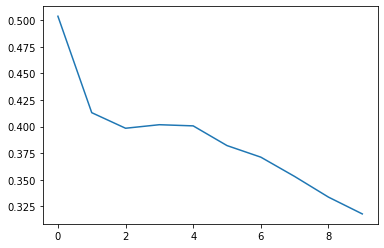

In [31]:
plt.figure()
plt.plot(valid_loss[0:-1])

In [ ]:
def train(learn, epochs, callbacks):
    cb_handler = CallbackHandler(callbacks)
    cb_handler.on_train_begin(epochs, learn)
    for epoch in range(epochs):
        learn.model.train()
        cb_nalder.on_epoch_begin(epoch)
        for xb, yb 

In [ ]:
bs         = 15
data       = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
Params     = init_params(len(Data.encoder),bs)
Params.sql = 30
Params.bs  = 15
data.train_dl = iter(TweetDataLoader(data.train.tweets[0:200],Params.bs,Params.sql))

### start coding 

In [ ]:
bs         = 15
data       = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
Params     = init_params(len(Data.encoder),bs)
Params.sql = 30
Params.bs  = 15
# dataloader = iter(TweetDataLoader(Data.train.tweets,Params.bs,Params.sql))
data.train_dl = iter(TweetDataLoader(data.train.tweets,Params.bs,Params.sql))

In [ ]:
plot_valid = []
# hidden = None
n_itter = 3000

learner = Learner(cuda(RNN(Params.in_sz, Params.hd_sz, 1)),nn.NLLLoss(),data)
learner,plot_valid = train_model(learner,Params,n_itter,plot_valid)

In [ ]:
generate_seq(rnn,Data,200)

In [ ]:
plt.figure()
plt.plot(plot_valid[1:-1])
plt.show()
print(plot_valid[-1])

In [ ]:
plt.figure()
# plt.plot(Plots.valid1[1:-1])
plt.plot(Plots.valid2[1:-1])
plt.show()

In [ ]:
def make_parentbatch(tweets, bs, sql, symbol='£'):
    f"""each parent-batch will have different numbers of sub-batches depending on how long the tweets are"""
    assert(len(tweets)/bs*10%2==0)
    bch_strs = batch_strings(tweets,bs,sql)
    parent_batches = []
    for pb in range(len(bch_strs)):
        bch       = bch_strs[pb]
        n_tweet   = bs
        n_segment = math.ceil(len(bch[0])/sql)
        sbx = torch.zeros(n_tweet,n_segment,sql,len(Data.decoder))
        sby = torch.zeros(n_tweet,n_segment,sql).long()

        for tweet in range(n_tweet):
            if re.search(symbol,bch[tweet]): position = re.search(symbol,bch[tweet]).span()[0]
            else:                            position = len(bch[tweet])
            x_str = change_char(bch[tweet],position-1,symbol)
            y_str = bch[tweet][1:len(bch[tweet])]+symbol                
            for segment in range(n_segment):
                x = x_str[sql*segment:sql*(segment+1)]
                y = y_str[sql*segment:sql*(segment+1)]  
                sbx[tweet,segment] = encodestr(x,Data.encoder)
                sby[tweet,segment] = torch.Tensor([Data.encoder[char] for char in y])                
                
        sb_ds = SBDataLoader(sbx, sby)
        parent_batches.append(sb_ds)
    return parent_batches

class ParentDataLoader():
    def __init__(self, ds): 
        self.ds = ds
    def __iter__(self):    
        for i in range(len(self.ds)):
            iterator = iter(self.ds[i])
            yield next(iterator), True
            try:
                while True:                
                    yield next(iterator), False 
            except StopIteration:
                pass
            
def train_model(learner,Params,n_itter,plot_valid=None,hidden=None):
#     optimizer = optim.Adam(model.parameters(), lr=Params.lr)
    
    start = time.time()
    if learner.opt is None: learner.opt = optim.RMSprop(learner.model.parameters(), lr=Params.lr)
    if plot_valid  is None: plot_valid  = []
    if hidden      is None: hidden      = learner.model.initHidden(Params.bs)    
        
    for i in range(n_itter):
        (X,Y), usezerostate     = next(data.train_dl)
        if usezerostate: hidden = learner.model.initHidden(Params.bs)

        loss = 0
        for char in range(X.shape[1]):
            x,y = X[:,char],Y[:,char]

            idx = zero_idx(y)
            if idx is None: break
            hidden = hidden[idx]
            x      = x[idx]
            y      = y[idx]
            
            output,hidden = learner.model.forward(x,hidden)
            loss += learner.loss_fn(output,y)
        if loss != 0:
            loss.backward()
            learner.opt.step()
            learner.opt.zero_grad()
            hidden = hidden.detach()

        if i%100==0: 
            plot_valid.append(get_valid_loss(learner.model,Data,Params,30,50))
        if i%500==0: print(f"""checkpoint: {i} itterations done in {time.time() - start} seconds""")

    print(f"""this training took {time.time()-start} seconds""")
    return learner,plot_valid,hidden            

### functions I should not need anymore